# Team 5 Hi! Hackathon 2022 

This notebook is a model with the objectives of detecting a car in an image and predict the CO2 footprint produced by this car only by image.
The final model can detect whether there is a car or not, the car position in the image (by a bounding box) and its CO2 footprint.

*Notice*

Please free all the memory of Hfactory VM in case of out of memory.

In [1]:
pip install efficientnet

  Using cached efficientnet-1.1.1-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [54]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os

# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import efficientnet.keras as efn
import glob
from tqdm import tqdm

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Path management

In [4]:
data_path = '../../datasets'

In [5]:
path_annotrain = data_path + "/datasets_train/train_annotation/_annotation.csv"

train_annotation = pd.read_csv(path_annotrain, index_col=0)

In [6]:
train_annotation.dropna(inplace=True)

In [7]:
train_annotation['class'].value_counts()

car           1304
Person         135
Eye             77
Food            53
Dog             43
              ... 
Zebra            1
Sunglasses       1
Gas stove        1
Spice rack       1
Goggles          1
Name: class, Length: 268, dtype: int64

In [8]:
train_annotation['class'] = (train_annotation['class'] == 'car')*1

In [9]:
train_annotation.head(3)

im_name  x_min  y_min   x_max  y_max  class                    models
0  107347968.jpg   40.0  244.0  1144.0  637.0      1  Audi S5 Convertible 2012
1   91160576.jpg    4.0    9.0    98.0   76.0      1       Audi 100 Wagon 1994
2  273809408.jpg   16.0    4.0   288.0  191.0      1     Cadillac SRX SUV 2012

In [10]:
train_annotation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2636 entries, 0 to 9872
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   im_name  2636 non-null   object 
 1   x_min    2636 non-null   float64
 2   y_min    2636 non-null   float64
 3   x_max    2636 non-null   float64
 4   y_max    2636 non-null   float64
 5   class    2636 non-null   int64  
 6   models   2636 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 164.8+ KB


In [11]:
path_data = data_path + "/datasets_train/train"

In [12]:
image_names = train_annotation['im_name'].to_list()
print("There are {} images for the training set of first model.".format(len(image_names)))

There are 2636 images for the training set of first model.


### Read datas and Images

In [13]:
foot_print_file =data_path+'/car_models_footprint.csv'
foot_print = pd.read_csv(foot_print_file, delimiter=';')
car_with_footprint = dict(zip(foot_print['models'],foot_print['Average of CO2 (g per km)']))
car_with_footprint[" "] = 0.0

In [14]:
train_annotation['CO2'] = train_annotation['models'].apply(lambda x: car_with_footprint[x])


Function to adapt input image to to input format of pretrained model.

In [15]:
def format_image(img_file, img_size):
    """
    This function reads and formats an image so that it can be fed to the inceptionv3 networks

    Parameters
    ----------
    img_file : image file name
    img_size : resize image so that the model can deal with images with the same size

    Returns
    -------
    img_out_model : the correctly formatted image for inceptionv3 networks
    """
    # read image, resize the image
    img = load_img(img_file)
    
    o_size = img_to_array(img).shape
    
    img = tf.image.resize(img, img_size)
    
    # convert image to an array
#     img_out = img_to_array(img)
    # preprocess the image to put in the correct format for use with the VGG16/inceptionv3 network trained on imagenet
    
    #https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input
    #The inputs pixel values are scaled between -1 and 1, sample-wise.
    img_out_model = tf.keras.applications.vgg16.preprocess_input(img)
    

    # add a dimension at the beginning, corresponding to the batch dimension
    # img_out_model = np.expand_dims(img_out_model, axis=0)
    return o_size[:2], img_out_model

In [16]:
input_size = (224, 224)

In [17]:
format_image(path_data+"/"+image_names[0], input_size)[0]

(782, 1280)

In [18]:
img = load_img(path_data+"/"+image_names[0])
img = tf.image.resize(img, (224,224))
img.shape
print(type(img))
# img_out = img_to_array(img)
img_out_model = tf.keras.applications.vgg16.preprocess_input(img)
img_out_model.shape

<class 'tensorflow.python.framework.ops.EagerTensor'>


TensorShape([224, 224, 3])

In [19]:
x_min = train_annotation['x_min'].to_list()
y_min = train_annotation['y_min'].to_list()
x_max = train_annotation['x_max'].to_list()
y_max = train_annotation['y_max'].to_list()
is_car = train_annotation['class'].to_list()
emission = train_annotation['CO2'].to_list()

In [20]:
def create_data_set(image_names, image_size):
    df_x = []
    df_box = []
    df_class = []
    df_emission=[]
    img_shapes = []
    for i in tqdm(range(len(image_names)), desc='Preprocessing dataset'):
        img_file = path_data + "/" + image_names[i]
        
        (h, w), img_out_model = format_image(img_file, image_size)
        img_shapes.append((h, w))
        df_x.append(img_out_model)
        
        box = np.array([x_min[i]/w, y_min[i]/h, x_max[i]/w, y_max[i]/h])
        df_box.append(box)
        df_emission.append(emission[i])
        
        df_class.append(is_car[i])
    print('Data collection finished.')
    df_box = np.stack(df_box)
    df_class = np.array(df_class)
    trainTargets = {
        "class_label": df_class,
        "bounding_box": df_box,
        "co2_emission": df_emission
    }
    return np.stack(df_x), trainTargets , img_shapes

In [21]:
X, y, img_shapes  = create_data_set(image_names, input_size)

Data collection finished.


In [22]:
import random
random.seed(10)
random_indices = np.arange(0,X.shape[0])
random.shuffle(random_indices)
random_indices

array([2184,  481,   61, ..., 1756,  133, 2340])

Normalizing the CO2 footprint

In [23]:
y["co2_emission"] = np.array(emission)

In [24]:
y_max = y["co2_emission"].max()
y["co2_emission"] /= y_max

In [25]:
y["co2_emission"]

array([0.34758017, 0.39391353, 0.64952513, ..., 0.        , 0.        ,
       0.        ])

In [26]:
train_size = int(0.8 * X.shape[0])

In [27]:
Y_train = {
        "class_label": y["class_label"][random_indices[:train_size]],
        "bounding_box": y["bounding_box"][random_indices[:train_size]],
        "co2_emission": y["co2_emission"][random_indices[:train_size]]
    }

Y_test = {
        "class_label": y["class_label"][random_indices[train_size:]],
        "bounding_box": y["bounding_box"][random_indices[train_size:]],
        "co2_emission": y["co2_emission"][random_indices[train_size:]]
    }

Train-test split

In [28]:
X_train, X_test = X[random_indices[:train_size]], X[random_indices[train_size:]]

### Model Building

Here we fine tune a pretrained VGG16 model with 3 output heads which work on predicting
1. The bounding box 
2. presence of car 
3. CO2 footprint.

In [29]:
# load the efficient network, ensuring the head FC layers are left off

vgg = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = True
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

In [30]:
bboxHead = Dense(128, activation="relu")(flatten)
# bboxHead = Dropout(0.5)(bboxHead)
# bboxHead = Dense(64, activation="relu")(bboxHead)
# bboxHead = Dropout(0.2)(bboxHead)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dropout(0.2)(bboxHead)
# bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)


softmaxHead = Dense(512, activation="relu")(flatten)
# softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(64, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(1, activation="sigmoid", name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label

co2head = Dense(128, activation="relu")(flatten)
# bboxHead = Dropout(0.5)(bboxHead)
# bboxHead = Dense(64, activation="relu")(bboxHead)
# bboxHead = Dropout(0.2)(bboxHead)
# co2head = Dense(64, activation="relu")(co2head)
# co2head = Dropout(0.2)(co2head)
co2head = Dense(64, activation="relu")(co2head)
co2head = Dropout(0.5)(co2head)
# co2head = Dense(32, activation="relu")(co2head)
co2head = Dense(16, activation="relu")(co2head)
# co2head = Dense(1, activation="relu")(co2head)
# co2head = tf.keras.layers.Multiply()([co2head, softmaxHead])
co2head = Dense(1, activation="sigmoid", name="co2_emission")(co2head)

model = Model(inputs=vgg.input,
                outputs=(bboxHead, softmaxHead, co2head))

In [31]:
INIT_LR = 1e-4
NUM_EPOCHS = 8
BATCH_SIZE = 64

In [32]:
losses = {
	"class_label": "binary_crossentropy",
	"bounding_box": "mean_absolute_error",
    "co2_emission": "mean_absolute_error"
}

lossWeights = {
	"class_label": 2,
	"bounding_box": 4,
    "co2_emission": 8
}

metrics = {
	"class_label": "accuracy",
	"bounding_box": "mean_absolute_error",
    "co2_emission": "mean_absolute_error"
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=metrics, loss_weights=lossWeights)
# print(model.summary())

In [33]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	X_train, Y_train,
    validation_data=(X_test, Y_test),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

[INFO] training model...
Epoch 1/8
33/33 [==============================] - 23s 359ms/step - loss: 2.0712 - bounding_box_loss: 0.1468 - class_label_loss: 0.2321 - co2_emission_loss: 0.1275 - bounding_box_mean_absolute_error: 0.1468 - class_label_accuracy: 0.9170 - co2_emission_mean_absolute_error: 0.1275 - val_loss: 1.6202 - val_bounding_box_loss: 0.1157 - val_class_label_loss: 0.1687 - val_co2_emission_loss: 0.1025 - val_bounding_box_mean_absolute_error: 0.1157 - val_class_label_accuracy: 0.9394 - val_co2_emission_mean_absolute_error: 0.1025
Epoch 2/8
33/33 [==============================] - 9s 284ms/step - loss: 1.1590 - bounding_box_loss: 0.1060 - class_label_loss: 0.0536 - co2_emission_loss: 0.0785 - bounding_box_mean_absolute_error: 0.1060 - class_label_accuracy: 0.9815 - co2_emission_mean_absolute_error: 0.0785 - val_loss: 1.3594 - val_bounding_box_loss: 0.1087 - val_class_label_loss: 0.1224 - val_co2_emission_loss: 0.0850 - val_bounding_box_mean_absolute_error: 0.1087 - val_clas

Defining a function to calculate IOU score

In [34]:
def IOU(xpred1, ypred1, xpred2, ypred2, x1, y1, x2, y2):
    x_inter1 = max(xpred1, x1)
    x_inter2 = min(xpred2, x2)
    y_inter1 = max(ypred1, y1)
    y_inter2 = min(ypred2, y2)
    
    width_inter = x_inter2 - x_inter1
    height_inter = y_inter2 - y_inter1
    
    area_inter = width_inter * height_inter
    
    width_box1 = xpred2 - xpred1
    height_box1 = ypred2 - ypred1
    width_box2 = x2 - x1
    height_box2 = y2 - y1
    
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    area_union = area_box1 + area_box2 - area_inter
    
    return area_inter/area_union

In [35]:
#Plot output on the image
def load_plot(idx, xpred1, ypred1, xpred2, ypred2, x1, y1, x2, y2, c_pred, c):

    im_name = train_annotation['im_name'].to_list()[idx]
    im = np.asanyarray(Image.open(f"{data_path}/datasets_train/train/{im_name}"))
    # Display the image
    plt.imshow(im)

    # Get the current reference
    ax = plt.gca()

    # Create a Rectangle patch
    rect1 = patches.Rectangle(
        (xpred1, ypred1), xpred2 - xpred1, ypred2 - ypred1, linewidth=1, edgecolor="r", facecolor="none", label='pred'
    )
    rect2 = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="b", facecolor="none", label='true'
    )
    iou = IOU(xpred1, ypred1, xpred2, ypred2, x1, y1, x2, y2)
    # Add the patch to the Axes
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    plt.title(f'IOU= {round(iou,2)}, true_CO2= {round(c*y_max,2)}, pred_CO2 = {round(c_pred[0][0]*y_max,2)}, MAPE= {round(abs(c_pred[0][0]-c)/c,2)}')
    plt.legend()
    plt.show()


# load_plot(im_test, x1, y1, x2, y2)

# load_plot(im_test, x1, y1, x2, y2)

Test on a random sample

In [36]:
k = 10
a, b, c_pred = model.predict(np.array([X_test[k]]))
xpred1, ypred1, xpred2, ypred2 = a.ravel()
idx = random_indices[train_size:][k]

In [37]:
im_name = train_annotation['im_name'].to_list()[idx]
img = load_img(f"{data_path}/datasets_train/train/{im_name}")
(h, w) = img_to_array(img).shape[:2]

In [38]:
x1, y1, x2, y2 = Y_test['bounding_box'][k]
c = Y_test['co2_emission'][k]

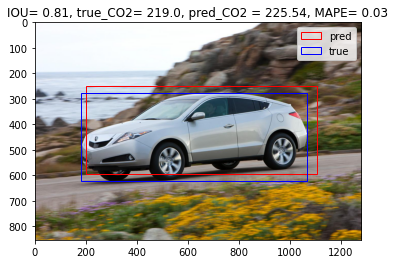

In [39]:
load_plot(idx, xpred1*w, ypred1*h, xpred2*w, ypred2*h, x1*w, y1*h, x2*w, y2*h, c_pred, c)

Test on a series of samples from the test set.

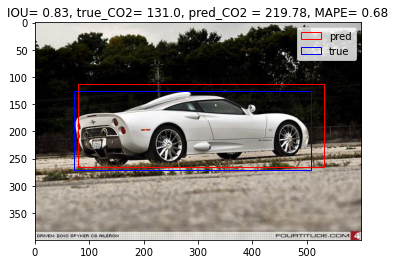

socre= 0.31957061285313015


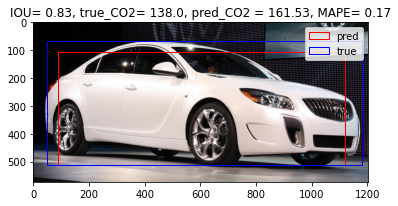

socre= 0.1681088680933358


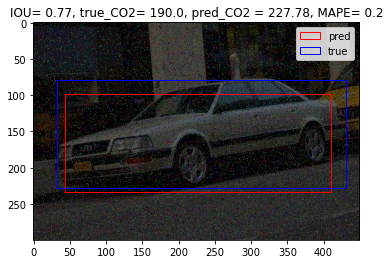

socre= 0.22010575816477257


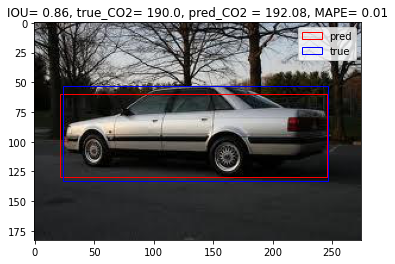

socre= 0.10302369597325053


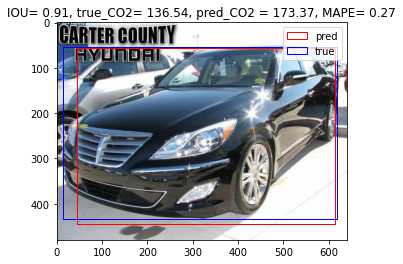

socre= 0.14537351772278942


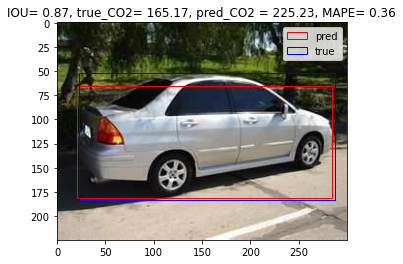

socre= 0.20103278606316222


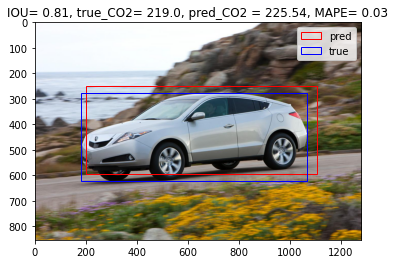

socre= 0.1445800846054571


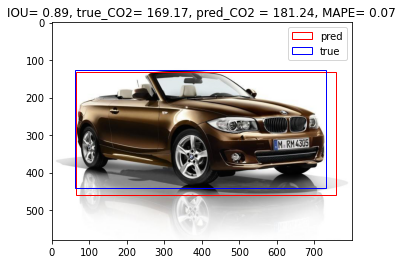

socre= 0.0988545243066238


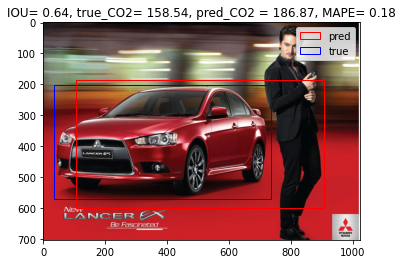

socre= 0.30241763739900157


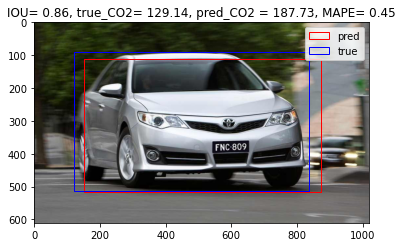

socre= 0.23221908721494777


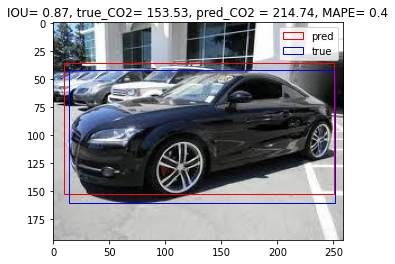

socre= 0.21345537248698426


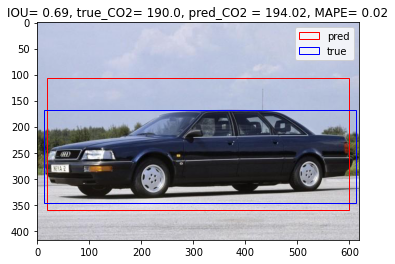

socre= 0.22335256884210009


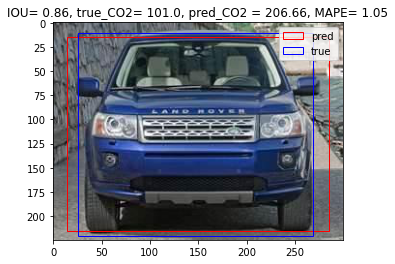

socre= 0.4121846774771172


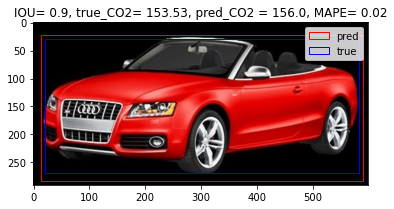

socre= 0.07353826933424881


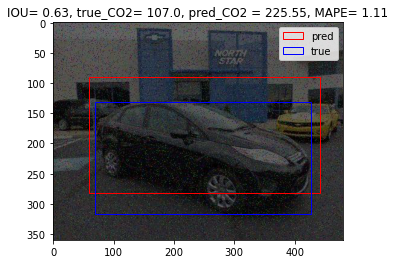

socre= 0.5940068109548373


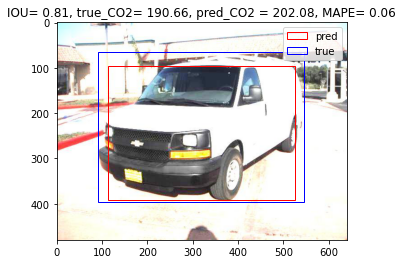

socre= 0.15436350951394653


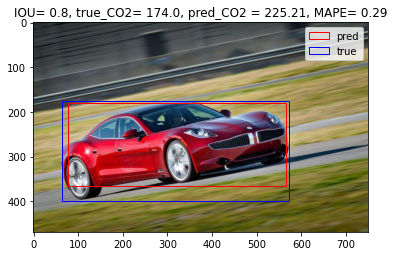

socre= 0.22943513364070595


/tmp/ipykernel_972/3351835579.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  plt.title(f'IOU= {round(iou,2)}, true_CO2= {round(c*y_max,2)}, pred_CO2 = {round(c_pred[0][0]*y_max,2)}, MAPE= {round(abs(c_pred[0][0]-c)/c,2)}')


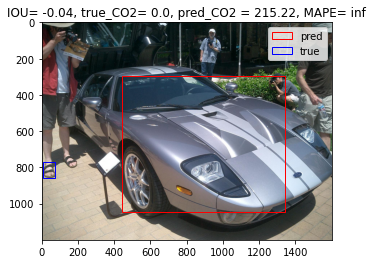

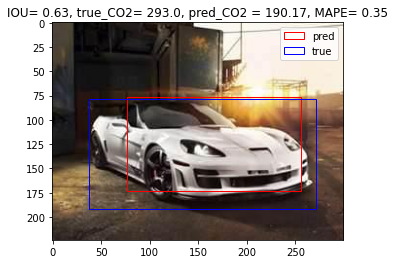

socre= 0.3638766398596394


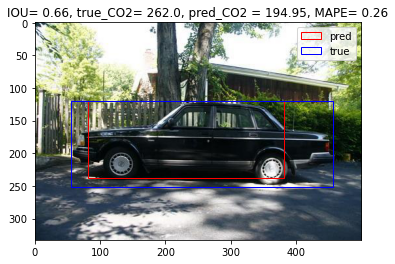

socre= 0.31300593383894537


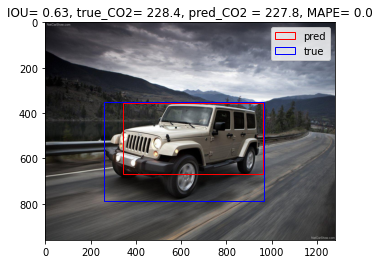

socre= 0.2581977604032883


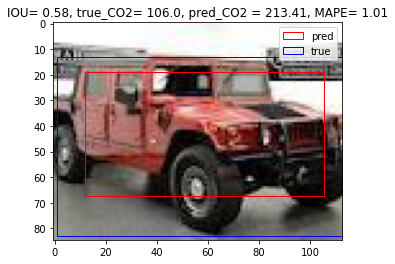

socre= 0.6008073180917857


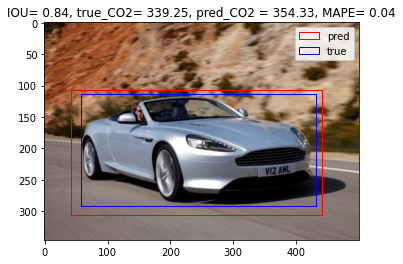

socre= 0.12749367431726896


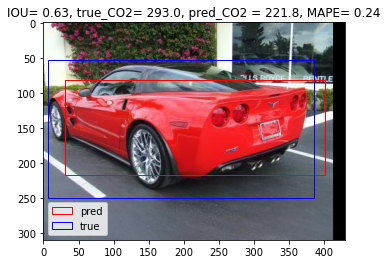

socre= 0.3335470043825739


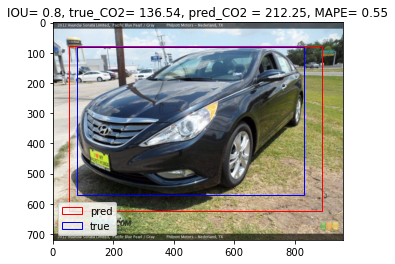

socre= 0.3029370202442158


In [40]:
mape_l = []
score_l = []
iou_l = []
for k in range(min(50,len(X_test))):
    a, b, c_pred = model.predict(np.array([X_test[k]]))
    if b>0.5:
        xpred1, ypred1, xpred2, ypred2 = a.ravel()
        c = Y_test['co2_emission'][k]
        idx = random_indices[train_size:][k]
        im_name = train_annotation['im_name'].to_list()[idx]
        img = load_img(f"{data_path}/datasets_train/train/{im_name}")
        (h, w) = img_to_array(img).shape[:2]
        x1, y1, x2, y2 = Y_test['bounding_box'][k]
        load_plot(idx, xpred1*w, ypred1*h, xpred2*w, ypred2*h, x1*w, y1*h, x2*w, y2*h, c_pred, c)
        iou = IOU(xpred1, ypred1, xpred2, ypred2, x1, y1, x2, y2)
        
        if c>0:
            mape = abs(c - c_pred[0][0])/c
            score = 0.3 * mape + 0.7 * (1-iou)
            iou = iou_l.append(iou)
            print(f'socre= {score}')
            mape_l.append(mape)
            score_l.append(score)
        

Test on training set.

In [41]:
# for k in range(200):
#     a, b = model.predict(np.array([X_train[k]]))
#     if b>0.5:
#         xpred1, ypred1, xpred2, ypred2 = a.ravel()
#         idx = random_indices[:2108][k]
#         im_name = train_annotation['im_name'].to_list()[idx]
#         img = load_img(f"{data_path}/datasets_train/train/{im_name}")
#         (h, w) = img_to_array(img).shape[:2]
#         x1, y1, x2, y2 = Y_train['bounding_box'][k]
#         load_plot(idx, xpred1*w, ypred1*h, xpred2*w, ypred2*h, x1*w, y1*h, x2*w, y2*h)
        

### Submission prediction

In [46]:
test_data_path = "../../datasets/datasets_test/test/"

In [47]:
test_ls = glob.glob(test_data_path+"*.jpg")

Load data

In [48]:
def create_test_data(image_names, image_size):
    df_x = []
    img_shapes = []
    for i in tqdm(range(len(image_names)),desc='Preprocessing test dataset'):
        img_file = image_names[i]
        
        (h, w), img_out_model = format_image(img_file, image_size)

        df_x.append(img_out_model)

    print('Data collection finished.')

    return np.stack(df_x)

In [49]:
data_to_test = create_test_data(test_ls, input_size)

Data collection finished.


Test data shape.

In [50]:
data_to_test.shape

(1024, 224, 224, 3)

In [51]:
prediction_box, is_car, c_pred = model.predict(data_to_test)

In [52]:
def load_plot_test(idx, xpred1, ypred1, xpred2, ypred2, c_pred):

    im_name = test_ls[idx]
    im = np.asanyarray(Image.open(im_name))
    # Display the image
    plt.imshow(im)

    # Get the current reference
    ax = plt.gca()

    # Create a Rectangle patch
    rect1 = patches.Rectangle(
        (xpred1, ypred1), xpred2 - xpred1, ypred2 - ypred1, linewidth=1, edgecolor="r", facecolor="none", label='pred'
    )
    
    # Add the patch to the Axes
    ax.add_patch(rect1)
    plt.title(f' pred_CO2 = {round(c_pred[0]*y_max,2)}')
    plt.legend()
    plt.show()


# load_plot(im_test, x1, y1, x2, y2)

# load_plot(im_test, x1, y1, x2, y2)

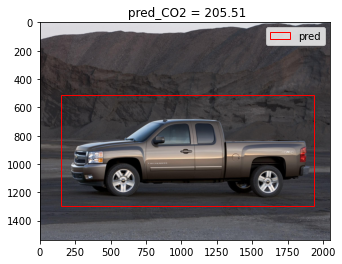

Car pred:  [0.9999665]


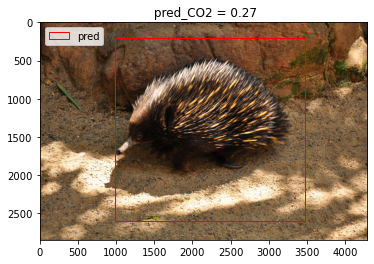

Car pred:  [6.8181276e-07]


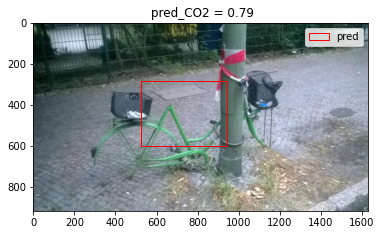

Car pred:  [0.04060727]


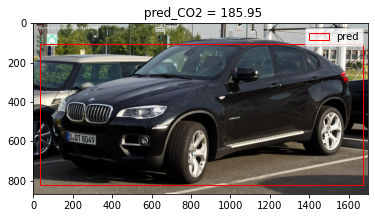

Car pred:  [1.]


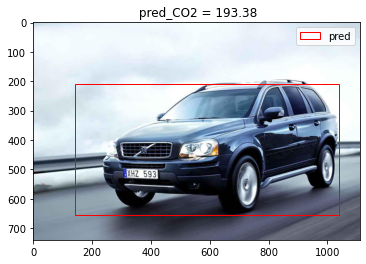

Car pred:  [1.]


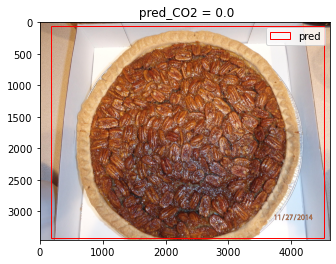

Car pred:  [1.0266082e-15]


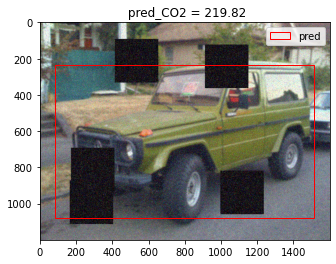

Car pred:  [0.999998]


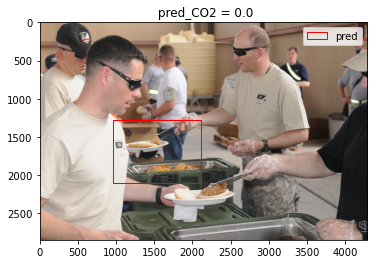

Car pred:  [2.363166e-08]


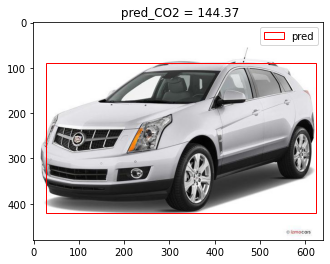

Car pred:  [1.]


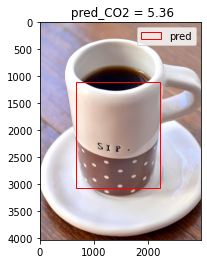

Car pred:  [0.00682426]


In [53]:
for idx in range(10):
    xpred1, ypred1, xpred2, ypred2 = prediction_box[idx].ravel()
    im_name = test_ls[idx]
    img = np.asanyarray(Image.open(im_name))
    h, w = img.shape[:2]
    cp = c_pred[idx]
    load_plot_test(idx, xpred1*w, ypred1*h, xpred2*w, ypred2*h, cp)
    print("Car pred: ", is_car[idx])
#     print(prediction_box[idx])

Make submission file.

In [ ]:
from tqdm import tqdm

In [ ]:
result = []
for i in tqdm(range(len(test_ls)), desc='process'):
    im_name = test_ls[i].split('/')[-1]
    img_path = test_ls[idx]
    img = np.asanyarray(Image.open(img_path))
    h, w = img.shape[:2]
    xpred1, ypred1, xpred2, ypred2 = prediction_box[i].ravel()
    left, top, right, bottom = xpred1*w, ypred1*h, xpred2*w, ypred2*h
    car_true = is_car[i]>0.5
    cp = c_pred[i][0]*y_max
    if not car_true:
        cp=0
        left, top, right, bottom = 0, 0, 0, 0
    result.append([im_name, left, top, right, bottom, cp])

    
    

In [ ]:
result = np.vstack(result)

In [ ]:
result_pd = pd.DataFrame(data=result, columns=['im_name','x_min','y_min','x_max','y_max','e'])

In [ ]:
result_pd[['x_min','y_min','x_max','y_max','e']] = result_pd[['x_min','y_min','x_max','y_max','e']].astype(float)

In [ ]:
#result_pd.to_csv('test_team.csv', index=False)